# Financial Timeseries - NBBO

One of the biggest technical challenges underlying problems in financial services is manipulating time series at scale. Another major challenge is centralizing the wide variety of time series data sources, effectively unlocking potential value. Tick data, alternative data sets such as geospatial or transactional data, and fundamental economic data are examples of the rich data sources available to financial institutions, all of which are naturally indexed by timestamp. Solving business problems in finance such as risk, fraud, and compliance ultimately rests on being able to aggregate and analyze thousands of time series in parallel.

In [1]:
!rm -rf ASOF_Trades.csv
!rm -rf ASOF_Quotes.csv
!rm -rf parquet
!rm -rf data
!mkdir data
!wget https://pages.databricks.com/rs/094-YMS-629/images/ASOF_Quotes.csv -O data/ASOF_Quotes.csv 
!wget https://pages.databricks.com/rs/094-YMS-629/images/ASOF_Trades.csv -O data/ASOF_Trades.csv ; 

--2022-12-14 08:38:31--  https://pages.databricks.com/rs/094-YMS-629/images/ASOF_Quotes.csv
Resolving pages.databricks.com (pages.databricks.com)... 104.17.70.206, 104.17.73.206, 104.17.74.206, ...
Connecting to pages.databricks.com (pages.databricks.com)|104.17.70.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72148443 (69M) [text/plain]
Saving to: ‘data/ASOF_Quotes.csv’

data/ASOF_Quotes.cs 100%[===================>]  68.81M   535KB/s    in 2m 9s   

2022-12-14 08:40:41 (544 KB/s) - ‘data/ASOF_Quotes.csv’ saved [72148443/72148443]

--2022-12-14 08:40:42--  https://pages.databricks.com/rs/094-YMS-629/images/ASOF_Trades.csv
Resolving pages.databricks.com (pages.databricks.com)... 104.17.70.206, 104.17.73.206, 104.17.74.206, ...
Connecting to pages.databricks.com (pages.databricks.com)|104.17.70.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53739980 (51M) [text/plain]
Saving to: ‘data/ASOF_Trades.csv’

data/ASOF_Trades.cs 10

In [2]:
import mlflow
from mlflow.tracking import MlflowClient
 
mlflow.set_tracking_uri("http://host.docker.internal:5000")
client = MlflowClient("http://host.docker.internal:5000")

In [3]:
from pyspark import SparkFiles
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('Finance_time_series').getOrCreate()

In [4]:
from pyspark.sql.types import *
 
trade_schema = StructType([
    StructField("symbol", StringType()),
    StructField("event_ts", TimestampType()),
    StructField("trade_dt", StringType()),
    StructField("trade_pr", DoubleType())
])
 
quote_schema = StructType([
    StructField("symbol", StringType()),
    StructField("event_ts", TimestampType()),
    StructField("trade_dt", StringType()),
    StructField("bid_pr", DoubleType()),
    StructField("ask_pr", DoubleType())
])
 
spark.read.format("csv").schema(trade_schema).option("header", "true").option("delimiter", ",").load("./data/ASOF_Trades.csv").write.mode('overwrite').format("parquet").save('./parquet/trades')
 
spark.read.format("csv").schema(quote_schema).option("header", "true").option("delimiter", ",").load("./data/ASOF_Quotes.csv").write.mode('overwrite').format("parquet").save('./parquet/quotes')

In [5]:
!rm -rf ASOF_Trades.csv
!rm -rf ASOF_Quotes.csv

In [6]:
from pyspark.sql.functions import *
 
trades = spark.read.format("parquet").load("./parquet/trades") \
                                   .withColumnRenamed("trade_pr", "price") \
                                   .withColumn("bid", lit(None).cast("double")) \
                                   .withColumn("offer", lit(None).cast("double")) \
                                   .withColumn("ind_cd", lit(1)) 
trades.show(5)
quotes = spark.read.format("parquet").load("./parquet/quotes") \
                                   .withColumn("price", lit("")) \
                                   .withColumnRenamed("bid_pr", "bid") \
                                   .withColumnRenamed("ask_pr", "offer") \
                                   .withColumn("ind_cd", lit(-1)) 
quotes.show(5)

+------+-------------------+----------+------------------+----+-----+------+
|symbol|           event_ts|  trade_dt|             price| bid|offer|ind_cd|
+------+-------------------+----------+------------------+----+-----+------+
|   KYN|2017-08-31 15:02:50|2017-08-31| 349.8680250096154|null| null|     1|
|   AMH|2017-08-31 07:41:00|2017-08-31| 347.1445085196848|null| null|     1|
|  EMIS|2017-08-31 18:24:13|2017-08-31| 348.0517165363705|null| null|     1|
|  EMIS|2017-08-31 22:38:15|2017-08-31| 348.0099924221828|null| null|     1|
|   AMH|2017-08-31 13:35:54|2017-08-31|348.22249748469386|null| null|     1|
+------+-------------------+----------+------------------+----+-----+------+
only showing top 5 rows

+------+-------------------+----------+------------------+------------------+-----+------+
|symbol|           event_ts|  trade_dt|               bid|             offer|price|ind_cd|
+------+-------------------+----------+------------------+------------------+-----+------+
|   AMH|2

In [7]:
un= trades.filter(col("symbol") == "K").select('event_ts', 'price', 'symbol', 'bid', 'offer', 'ind_cd').union(quotes.filter(col("symbol") == "K").select('event_ts', 'price', 'symbol', 'bid', 'offer', 'ind_cd'))
 
un.show(5)

+-------------------+------------------+------+----+-----+------+
|           event_ts|             price|symbol| bid|offer|ind_cd|
+-------------------+------------------+------+----+-----+------+
|2017-08-31 03:50:20| 348.6119516556592|     K|null| null|     1|
|2017-08-31 23:29:40| 348.9429200005411|     K|null| null|     1|
|2017-08-31 19:25:27|348.16797905143034|     K|null| null|     1|
|2017-08-31 01:08:30| 347.8078868655896|     K|null| null|     1|
|2017-08-31 08:52:59|349.11648025163987|     K|null| null|     1|
+-------------------+------------------+------+----+-----+------+
only showing top 5 rows



In [8]:

mkt_hrs_trades = trades.filter(col("symbol") == "K"). \
                        filter(col("event_ts") >= "2017-08-31 06:29"). \
                        filter(col("event_ts") <= "2017-08-31 16:00:00")
 
#mkt_hrs_trades_ts = base_ts(mkt_hrs_trades)
#quotes_ts = quotes.filter(col("symbol") == "K")
 
#mkt_hrs_trades_ts.join(quotes_ts).show()

In [9]:
left = mkt_hrs_trades.select(col('event_ts'), col('price'), col('symbol'), col('bid'), col('offer'), col('ind_cd'))
right = quotes.filter(col("symbol") == "K").select('event_ts', 'price', 'symbol', 'bid', 'offer', 'ind_cd')
un = left.union(right)
un.show(5)

+-------------------+------------------+------+----+-----+------+
|           event_ts|             price|symbol| bid|offer|ind_cd|
+-------------------+------------------+------+----+-----+------+
|2017-08-31 08:52:59|349.11648025163987|     K|null| null|     1|
|2017-08-31 09:22:55|347.16036576622395|     K|null| null|     1|
|2017-08-31 06:56:24|349.45235333868743|     K|null| null|     1|
|2017-08-31 10:52:36|348.44707325529976|     K|null| null|     1|
|2017-08-31 08:38:22| 347.6687817715506|     K|null| null|     1|
+-------------------+------------------+------+----+-----+------+
only showing top 5 rows



In [10]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
import pyspark.sql.functions as fn
from pyspark.sql.window import Window
 
import pandas as pd
partition_spec = Window.partitionBy('symbol')
# define sort - the ind_cd is the indicator of whether the record type is a trade or quote (or whatever needs to be sorted first)
join_spec = partition_spec.orderBy('event_ts', 'ind_cd').rowsBetween(Window.unboundedPreceding, Window.currentRow)
# use the last_value functionality to get the latest effective record (quote) and attach to the trade proceeding the quote
last_val_un=un.select(col('event_ts'), col('price'), col('symbol'), col('ind_cd'), fn.last("bid", True).over(join_spec).alias("latest_bid"), fn.last("offer", True).over(join_spec).alias("latest_offer"))
last_val_un.show(5)

+-------------------+-----------------+------+------+-----------------+------------------+
|           event_ts|            price|symbol|ind_cd|       latest_bid|      latest_offer|
+-------------------+-----------------+------+------+-----------------+------------------+
|2017-08-31 05:26:27|                 |     K|    -1|346.4944228537921| 349.4160317662645|
|2017-08-31 06:21:20|                 |     K|    -1|346.0297772384752|350.39315623662594|
|2017-08-31 06:29:58|347.4121586706382|     K|     1|346.0297772384752|350.39315623662594|
|2017-08-31 06:32:30|346.7582132240916|     K|     1|346.0297772384752|350.39315623662594|
|2017-08-31 06:37:31| 348.919146315238|     K|     1|346.0297772384752|350.39315623662594|
+-------------------+-----------------+------+------+-----------------+------------------+
only showing top 5 rows



In [11]:
last_val_un.filter(col('ind_cd') ==1).show(5)

+-------------------+------------------+------+------+------------------+------------------+
|           event_ts|             price|symbol|ind_cd|        latest_bid|      latest_offer|
+-------------------+------------------+------+------+------------------+------------------+
|2017-08-31 06:29:58| 347.4121586706382|     K|     1| 346.0297772384752|350.39315623662594|
|2017-08-31 06:32:30| 346.7582132240916|     K|     1| 346.0297772384752|350.39315623662594|
|2017-08-31 06:37:31|  348.919146315238|     K|     1| 346.0297772384752|350.39315623662594|
|2017-08-31 06:56:24|349.45235333868743|     K|     1| 346.0297772384752|350.39315623662594|
|2017-08-31 08:38:22| 347.6687817715506|     K|     1|345.46234681384203| 348.8679460367136|
+-------------------+------------------+------+------+------------------+------------------+
only showing top 5 rows



In [12]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
import pyspark.sql.functions as fn
from pyspark.sql.window import Window
 
import pandas as pd
 
class base_ts:
  
    def __init__(self, df):
        self.df = df
        
    # define custom data frame join which can scale to billions of quotes - this does not need to perform a full inner join but rather a UNION/SORT
    def join(self, other):
        """Returns the latest right value effective at the time of the left timestamp
        :param other: Right side of the dataset being evaluted
        """
        # select common fields to merge in single format
        left = self.df.select(col('event_ts'), col('price'), col('symbol'), col('bid'), col('offer'), col('ind_cd'))
        right = other.select('event_ts', 'price', 'symbol', 'bid', 'offer', 'ind_cd')
        un = left.union(right)
        
        # define partitioning keys for window
        partition_spec = Window.partitionBy('symbol')
        
        # define sort - the ind_cd is the indicator of whether the record type is a trade or quote (or whatever needs to be sorted first)
        join_spec = partition_spec.orderBy('event_ts', 'ind_cd').rowsBetween(Window.unboundedPreceding, Window.currentRow)
        
        # use the last_value functionality to get the latest effective record (quote) and attach to the trade proceeding the quote
        last_val_un=un.select(col('event_ts'), col('price'), col('symbol'), col('ind_cd'), fn.last("bid", True).over(join_spec).alias("latest_bid"), fn.last("offer", True).over(join_spec).alias("latest_offer"))
        return last_val_un.filter(col('ind_cd') ==1)
      
    def vwap(self, frequency='m'):
      
        # set pre_vwap as self or enrich with the frequency
        pre_vwap = self.df
        if frequency == 'm':
            pre_vwap = self.df.withColumn("time_group", concat(lpad(hour(col("event_ts")), 2, '0'), lit(':'), lpad(minute(col('event_ts')), 2, '0'))) 
        elif frequency == 'H':
            pre_vwap = self.df.withColumn("time_group", concat(lpad(hour(col("event_ts")), 2, '0')))
        elif frequency == 'D':
            pre_vwap = self.df.withColumn("time_group", concat(lpad(day(col("event_ts")), 2, '0')))

        vwapped = pre_vwap.withColumn("dllr_value", col("price")*col("volume")).groupby('symbol', 'time_group').agg(sum('dllr_value').alias("dllr_value"), sum('volume').alias("volume"), max('price').alias("max_price")).withColumn("vwap", col("dllr_value")/col("volume"))
        return vwapped

In [13]:
trade_ts = base_ts(trades.select('event_ts', 'symbol', 'price', lit(100).alias("volume")))
 
vwap_df = trade_ts.vwap(frequency = 'm')
 
vwap_df.filter(col('symbol') == "K").filter(col('time_group').between('09:30', '16:00')).orderBy('time_group').show()

+------+----------+------------------+------+------------------+------------------+
|symbol|time_group|        dllr_value|volume|         max_price|              vwap|
+------+----------+------------------+------+------------------+------------------+
|     K|     10:00|34848.693109699074|   100| 348.4869310969907|348.48693109699076|
|     K|     10:52| 34844.70732552998|   100|348.44707325529976|348.44707325529976|
|     K|     12:47| 34926.17047407556|   100| 349.2617047407556| 349.2617047407556|
|     K|     13:17| 69636.77026098539|   200|349.16422862658777| 348.1838513049269|
|     K|     13:42| 35035.94725526159|   100| 350.3594725526159| 350.3594725526159|
|     K|     14:53| 34593.84837375688|   100| 345.9384837375688|345.93848373756884|
|     K|     15:14|34639.476308515324|   100| 346.3947630851533| 346.3947630851533|
+------+----------+------------------+------+------------------+------------------+



In [14]:
!mkdir data;wget https://s3-us-west-2.amazonaws.com/tick-data-s3/downloads/SampleEquityData_US.zip -O data/SampleEquityData_US.zip; unzip data/SampleEquityData_US.zip -d data

mkdir: cannot create directory ‘data’: File exists
--2022-12-14 08:42:48--  https://s3-us-west-2.amazonaws.com/tick-data-s3/downloads/SampleEquityData_US.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.196.208, 52.218.252.40, 52.218.182.72, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.196.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45852068 (44M) [application/octet-stream]
Saving to: ‘data/SampleEquityData_US.zip’

data/SampleEquityDa 100%[===================>]  43.73M  92.8KB/s    in 6m 21s  

2022-12-14 08:49:12 (117 KB/s) - ‘data/SampleEquityData_US.zip’ saved [45852068/45852068]

Archive:  data/SampleEquityData_US.zip
   creating: data/CompanyInfo/
  inflating: data/CompanyInfo/CompanyInfo.asc  
  inflating: data/CompanyInfo/Dividends.csv  
  inflating: data/CompanyInfo/Mergers.csv  
  inflating: data/CompanyInfo/StockSplits.csv  
   creating: data/OMED/
  inflating: data/OMED/14081.

In [22]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, concat, to_date, unix_timestamp, lit
 
quote_schema = StructType([
    StructField("symbol", StringType()),
    StructField("event_ts", TimestampType()),
    StructField("trade_dt", StringType()),
    StructField("bid_pr", DoubleType()),
    StructField("ask_pr", DoubleType()),
    StructField("bid_shrs_qt", IntegerType()),
    StructField("ask_shrs_qt", IntegerType())
])
 
spark.read.format("csv").option("header", "true").option("delimiter", ",").load("./data/NBBO/14081.csv"). \
                         withColumn("bid_shrs_qt", 100*col("Bid Size")). \
                         withColumn("ask_shrs_qt", 100*col("Ask Size")). \
                         withColumnRenamed("Bid Price", "bid_pr"). \
                         withColumnRenamed("Ask Price", "ask_pr"). \
                         withColumn("event_ts", concat(to_date((unix_timestamp(col("Date"), 'MM/dd/yyyy')).cast("timestamp")), lit(' '), col("Time")).cast("timestamp")). \
                         drop("Bid Size"). \
                         drop("Ask Size"). \
                         drop("Bid Exchange"). \
                         drop("Ask Exchange"). \
                         write.mode('overwrite').mode('overwrite').format("parquet").save('./parquet/ofi_quotes2')

In [24]:

import pandas as pd 
 
kdf = pd.read_parquet("./parquet/ofi_quotes2")
kdf_src = kdf.loc[kdf.Date == '03/05/2014']
kdf_src.head()

,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt,event_ts
44466,ITT,03/05/2014,09:30:00.038,43.32,43.91,300.0,300.0,2014-03-05 09:30:00.038
44467,ITT,03/05/2014,09:30:00.123,43.32,43.91,300.0,600.0,2014-03-05 09:30:00.123
44468,ITT,03/05/2014,09:30:00.246,43.32,43.9,300.0,100.0,2014-03-05 09:30:00.246
44469,ITT,03/05/2014,09:30:01.000,43.33,43.9,100.0,100.0,2014-03-05 09:30:01.000
44470,ITT,03/05/2014,09:30:01.001,43.33,43.89,100.0,300.0,2014-03-05 09:30:01.001


In [28]:
grouped_kdf = kdf_src.groupby(['event_ts'], as_index=False).max()
grouped_kdf.sort_values(by=['event_ts'])
grouped_kdf.head()

,event_ts,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt
0,2014-03-05 09:30:00.038,ITT,03/05/2014,09:30:00.038,43.32,43.91,300.0,300.0
1,2014-03-05 09:30:00.123,ITT,03/05/2014,09:30:00.123,43.32,43.91,300.0,600.0
2,2014-03-05 09:30:00.246,ITT,03/05/2014,09:30:00.246,43.32,43.9,300.0,100.0
3,2014-03-05 09:30:01.000,ITT,03/05/2014,09:30:01.000,43.33,43.9,100.0,100.0
4,2014-03-05 09:30:01.001,ITT,03/05/2014,09:30:01.001,43.33,43.89,100.0,300.0


In [29]:
grouped_kdf.set_index('event_ts', inplace=True, drop=True)
lag_grouped_kdf = grouped_kdf.shift(periods=1, fill_value=0)
 
lag_grouped_kdf.head()

,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt
event_ts,,,,,,,
2014-03-05 09:30:00.038,0,0,0,0,0,0.0,0.0
2014-03-05 09:30:00.123,ITT,03/05/2014,09:30:00.038,43.32,43.91,300.0,300.0
2014-03-05 09:30:00.246,ITT,03/05/2014,09:30:00.123,43.32,43.91,300.0,600.0
2014-03-05 09:30:01.000,ITT,03/05/2014,09:30:00.246,43.32,43.9,300.0,100.0
2014-03-05 09:30:01.001,ITT,03/05/2014,09:30:01.000,43.33,43.9,100.0,100.0


In [30]:
lagged = grouped_kdf.merge(lag_grouped_kdf, left_index=True, right_index=True, suffixes=['', '_lag'])
, axis=1).head()

,Symbol,Date,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt,Symbol_lag,Date_lag,Time_lag,bid_pr_lag,ask_pr_lag,bid_shrs_qt_lag,ask_shrs_qt_lag
event_ts,,,,,,,,,,,,,,
2014-03-05 09:30:00.038,ITT,03/05/2014,09:30:00.038,43.32,43.91,300.0,300.0,0,0,0,0,0,0.0,0.0
2014-03-05 09:30:00.123,ITT,03/05/2014,09:30:00.123,43.32,43.91,300.0,600.0,ITT,03/05/2014,09:30:00.038,43.32,43.91,300.0,300.0
2014-03-05 09:30:00.246,ITT,03/05/2014,09:30:00.246,43.32,43.9,300.0,100.0,ITT,03/05/2014,09:30:00.123,43.32,43.91,300.0,600.0
2014-03-05 09:30:01.000,ITT,03/05/2014,09:30:01.000,43.33,43.9,100.0,100.0,ITT,03/05/2014,09:30:00.246,43.32,43.9,300.0,100.0
2014-03-05 09:30:01.001,ITT,03/05/2014,09:30:01.001,43.33,43.89,100.0,300.0,ITT,03/05/2014,09:30:01.000,43.33,43.9,100.0,100.0


In [36]:
lagged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8370 entries, 2014-03-05 09:30:00.038000 to 2014-03-05 15:59:59.913000
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Symbol           8370 non-null   object 
 1   Date             8370 non-null   object 
 2   Time             8370 non-null   object 
 3   bid_pr           8370 non-null   object 
 4   ask_pr           8370 non-null   object 
 5   bid_shrs_qt      8370 non-null   float64
 6   ask_shrs_qt      8370 non-null   float64
 7   Symbol_lag       8370 non-null   object 
 8   Date_lag         8370 non-null   object 
 9   Time_lag         8370 non-null   object 
 10  bid_pr_lag       8370 non-null   object 
 11  ask_pr_lag       8370 non-null   object 
 12  bid_shrs_qt_lag  8370 non-null   float64
 13  ask_shrs_qt_lag  8370 non-null   float64
dtypes: float64(4), object(10)
memory usage: 1.2+ MB


In [37]:
q = lagged
 
# compute supply and demand from the merged data frame
lagged['incr_demand'] = lagged.apply(lambda lag : 1 if float(lag.bid_pr) >= float(lag.bid_pr_lag) else 0, axis=1)
lagged['decr_demand'] = lagged.apply(lambda lag : 1 if float(lag.bid_pr) <= float(lag.bid_pr_lag) else 0, axis=1)
lagged['incr_supply'] = lagged.apply(lambda lag : 1 if float(lag.ask_pr) <= float(lag.ask_pr_lag) else 0, axis=1)
lagged['decr_supply'] = lagged.apply(lambda lag : 1 if float(lag.ask_pr) >= float(lag.ask_pr_lag) else 0, axis=1)
 
# perform arithmetic using koalas, avoid Spark syntax
lagged['imblnc_contrib'] = lagged['bid_shrs_qt']*lagged['incr_demand'] - lagged['bid_shrs_qt_lag']*lagged['decr_demand'] - lagged['ask_shrs_qt']*lagged['incr_supply'] + lagged['ask_shrs_qt_lag']*lagged['decr_supply']
 
lagged[['Symbol', 'Time', 'bid_pr', 'ask_pr', 'bid_shrs_qt', 'ask_shrs_qt', 'bid_shrs_qt_lag', 'ask_shrs_qt_lag', 'imblnc_contrib']].head()


,Symbol,Time,bid_pr,ask_pr,bid_shrs_qt,ask_shrs_qt,bid_shrs_qt_lag,ask_shrs_qt_lag,imblnc_contrib
event_ts,,,,,,,,,
2014-03-05 09:30:00.038,ITT,09:30:00.038,43.32,43.91,300.0,300.0,0.0,0.0,300.0
2014-03-05 09:30:00.123,ITT,09:30:00.123,43.32,43.91,300.0,600.0,300.0,300.0,-300.0
2014-03-05 09:30:00.246,ITT,09:30:00.246,43.32,43.9,300.0,100.0,300.0,600.0,-100.0
2014-03-05 09:30:01.000,ITT,09:30:01.000,43.33,43.9,100.0,100.0,300.0,100.0,100.0
2014-03-05 09:30:01.001,ITT,09:30:01.001,43.33,43.89,100.0,300.0,100.0,100.0,-300.0


In [38]:
from scipy.stats import t
import scipy.stats as st
import numpy as np
 
q_ofi_values = lagged['imblnc_contrib'].to_numpy()

In [39]:
bins=200
data = q_ofi_values[1:]
 
 
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins)
    x = (x + np.roll(x, -1))[:-1] / 2.0
 
    # Distributions to check
    DISTRIBUTIONS = [        
        st.laplace, st.dgamma, st.powerlaw
    ]
 
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    other_distribution = st.norm
    other_params = (0.0, 1.0)
    other_sse = np.info
 
    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Ignore warnings from data that can't be fit
            # fit dist to data
        params = distribution.fit(data)
 
        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1] 
 
        # Calculate fitted PDF and error with fit in distribution
        pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))
 
        # if axis pass in add to plot
        try:
            if ax:
                pd.Series(pdf, x).plot(ax=ax)
            end
        except Exception:
            'FAILURE FITTING!'
 
        # identify if this distribution is better
        if best_sse > sse > 0:
            best_distribution = distribution
            best_params = params
            best_sse = sse
 
    return (best_distribution.name, best_params)

In [42]:
best_fit_distribution(data)

('dgamma', (1.9665995391512165, -28.05159439242201, 68.7480918274797))

In [45]:
ub=68
lb = -28

/tmp/ipykernel_22874/3097447005.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


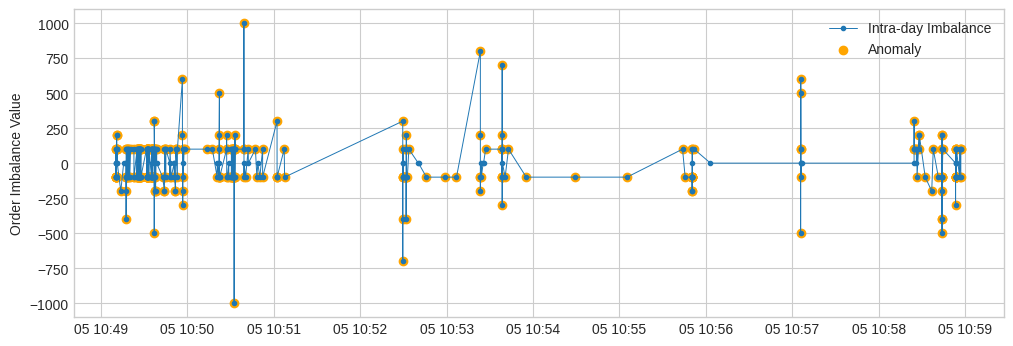

None

<Figure size 640x480 with 0 Axes>

In [46]:
# Start and end of the date range to extract
import seaborn as sns
import matplotlib.pyplot as plt
 
plt.style.use('seaborn-whitegrid')
 
start, end = '2014-03-05 10:49:00', '2014-03-05 10:59:00'
lagged_pdf = lagged[['imblnc_contrib']]
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(lagged_pdf['imblnc_contrib'][start:end], marker='o', markersize='3', linestyle='-', linewidth=0.7, label='Intra-day Imbalance')
ax.scatter(x = lagged_pdf[(lagged_pdf['imblnc_contrib'] > ub) | (lagged_pdf['imblnc_contrib'] < lb)]['imblnc_contrib'][start:end].index, y = lagged_pdf[(lagged_pdf['imblnc_contrib'] > ub) | (lagged_pdf['imblnc_contrib'] < lb)]['imblnc_contrib'][start:end], color = 'orange', label='Anomaly')
 
ax.set_ylabel('Order Imbalance Value')
ax.legend();
 
fig = plt.show()
display(fig)
 
plt.gcf().clear()

In [47]:
!rm -rf parquet
!rm -rf data